In [58]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np

print("GPU is", "available" if tf.config.experimental.list_physical_devices("XLA_GPU") else "NOT AVAILABLE")
print("Tensorflow Version: ", tf.__version__)

GPU is available
Tensorflow Version:  2.2.0


In [59]:
(train_data, test_data), info = tfds.load(
    # Use the version pre-encoded with an ~8k vocabulary.
    'imdb_reviews/subwords8k', 
    # Return the train/test datasets as a tuple.
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    # Return (example, label) pairs from the dataset (instead of a dictionary).
    as_supervised=True,
    # Also return the `info` structure. 
    with_info=True)

In [60]:
encoder = info.features['text'].encoder
print("Vocabulary size: {}".format(encoder.vocab_size))

Vocabulary size: 8185


In [61]:
sample_string = "I run Arch Linux"

encoded_string = encoder.encode(sample_string)
print("Encoded string is {}".format(encoded_string))

original_string = encoder.decode(encoded_string)
print("Original string is {}".format(original_string))

assert original_string == sample_string

Encoded string is [12, 944, 758, 591, 2535, 8046, 8049]
Original string is I run Arch Linux


In [62]:
for sth in encoded_string:
    print("{} -----> {}".format(sth, encoder.decode([sth])))

12 -----> I 
944 -----> run 
758 -----> Ar
591 -----> ch 
2535 -----> Lin
8046 -----> u
8049 -----> x


In [63]:
for train_example, train_label in train_data.take(1):
    print("Encoded text:", train_example[:10].numpy())
    print("Label:", train_label.numpy())

Encoded text: [  62   18   41  604  927   65    3  644 7968   21]
Label: 0


In [64]:
encoder.decode(train_example)

"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

In [65]:
BUFFER_SIZE = 1000

train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(32)
)

test_batches = (
    test_data
    .padded_batch(32)
)

In [66]:
for example_batch, label_batch in train_batches.take(2):
    print("Batch shape: ", example_batch.shape)
    print("Label shape: ", label_batch.shape)

Batch shape:  (32, 858)
Label shape:  (32,)
Batch shape:  (32, 1217)
Label shape:  (32,)


In [67]:
brain = keras.Sequential([
    keras.layers.Embedding(encoder.vocab_size, 16),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(1)]
)
brain.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d_4 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


In [68]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy']
)

In [69]:
history = model.fit(train_batches,
                    epochs = 10,
                    validation_data = test_batches,
                    validation_steps = 30
)

Epoch 1/10
782/782 [==============================] - 7s 9ms/step - loss: 0.1870 - accuracy: 0.9303 - val_loss: 0.3473 - val_accuracy: 0.8667
Epoch 2/10
782/782 [==============================] - 7s 9ms/step - loss: 0.1812 - accuracy: 0.9319 - val_loss: 0.3574 - val_accuracy: 0.8583
Epoch 3/10
782/782 [==============================] - 7s 9ms/step - loss: 0.1751 - accuracy: 0.9347 - val_loss: 0.3514 - val_accuracy: 0.8667
Epoch 4/10
782/782 [==============================] - 7s 9ms/step - loss: 0.1719 - accuracy: 0.9357 - val_loss: 0.3551 - val_accuracy: 0.8635
Epoch 5/10
782/782 [==============================] - 7s 9ms/step - loss: 0.1672 - accuracy: 0.9381 - val_loss: 0.3633 - val_accuracy: 0.8625
Epoch 6/10
782/782 [==============================] - 7s 9ms/step - loss: 0.1629 - accuracy: 0.9404 - val_loss: 0.3618 - val_accuracy: 0.8635
Epoch 7/10
782/782 [==============================] - 7s 9ms/step - loss: 0.1583 - accuracy: 0.9429 - val_loss: 0.3717 - val_accuracy: 0.8625
Epoch 

In [70]:
loss, accuracy = model.evaluate(test_batches)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 3ms/step - loss: 0.3401 - accuracy: 0.8687
Loss:  0.34005239605903625
Accuracy:  0.8687199950218201


In [71]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

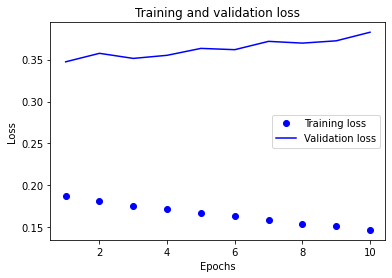

In [72]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

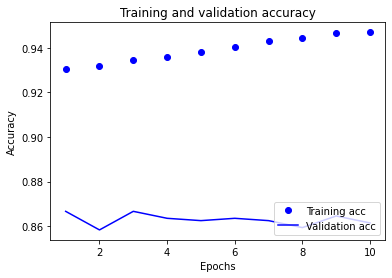

In [73]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()